In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
# %matplotlib inline
%config Completer.use_jedi = False

In [2]:
from datasets import InsectImgDataset
from utils import *
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import albumentations as A

from torchvision import datasets, transforms
import torch.optim as optim
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

from category_encoders import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.utils import class_weight

setting = 'photobox'
if setting == 'photobox':
    ext = '.png'
elif setting == 'fuji':
    ext = '.jpg'

Available workers: 8


In [3]:
dfs = InsectImgDataset(ext=ext, setting=setting, directory=DATA_DIR)
dfs.extract_df_info()
df = dfs.df

Extracting info from filenames..: 100%|█| 26938/26938 [00:03<00:00, 8106.75it/s]


# Creating train,val,test sets

## Removing outliers

In [4]:
df_pre = pd.read_parquet(f"{SAVE_DIR}/df_preparation_{setting}.parquet")
df = pd.merge(df,df_pre, on=['filename','label','platename','imgname','date','year','plate_idx','location','xtra'])
df = df[df.knn_outlier==0]
df = df[df.nb_contours>0]

oe = OrdinalEncoder(cols=['label'],mapping=[{'col':'label', 'mapping':{'bl':0,'wswl':1,'sp':2,'t':3,'sw':4,'k':5,'m':6,'c':7,'v':8,'wmv':9,'wrl':10}}])
df['txt_label'] = df['label']
df['label'] = oe.fit_transform(df.label)
df.head()

,filename,label,imgname,platename,year,location,date,xtra,plate_idx,blur,...,mean_cnt_area,mean_cnt_perimeter,std_cnt_area,std_cnt_perimeter,R,G,B,knn_outlier,knn_outlier_score,txt_label
0,/media/HGST_4TB/Datasets/photobox_vs_fuji/phot...,0,2020_herent_w27_1-30_4056x3040_23062020145640....,herent_w27_1-30_4056x3040_23062020145640.jpg,2020,herent,w27,1-30,24489,25.307896,...,60.870968,16.198733,835.417788,101.347855,133.678222,142.086978,129.338667,0,0.553638,bl
1,/media/HGST_4TB/Datasets/photobox_vs_fuji/phot...,0,2020_herent_w27_1-30_4056x3040_23062020145640....,herent_w27_1-30_4056x3040_23062020145640.jpg,2020,herent,w27,1-30,24493,21.129386,...,54.502994,16.757472,555.751472,80.321145,136.486622,148.774933,143.012622,0,0.348086,bl
2,/media/HGST_4TB/Datasets/photobox_vs_fuji/phot...,0,2020_herent_w27_1-30_4056x3040_23062020145640....,herent_w27_1-30_4056x3040_23062020145640.jpg,2020,herent,w27,1-30,24530,25.211150,...,31.208333,16.667472,155.566533,49.494496,146.883956,154.641333,143.112933,0,0.153271,bl
3,/media/HGST_4TB/Datasets/photobox_vs_fuji/phot...,0,2020_herent_w27_1-30_4056x3040_23062020145640....,herent_w27_1-30_4056x3040_23062020145640.jpg,2020,herent,w27,1-30,24532,34.813996,...,46.980226,14.289273,555.609924,87.069623,137.986843,144.721766,132.789095,0,0.398942,bl
4,/media/HGST_4TB/Datasets/photobox_vs_fuji/phot...,0,2020_herent_w27_1-30_4056x3040_23062020145640....,herent_w27_1-30_4056x3040_23062020145640.jpg,2020,herent,w27,1-30,24533,26.020966,...,40.770492,14.595134,497.758073,75.285206,136.351511,146.648489,137.386533,0,0.469810,bl


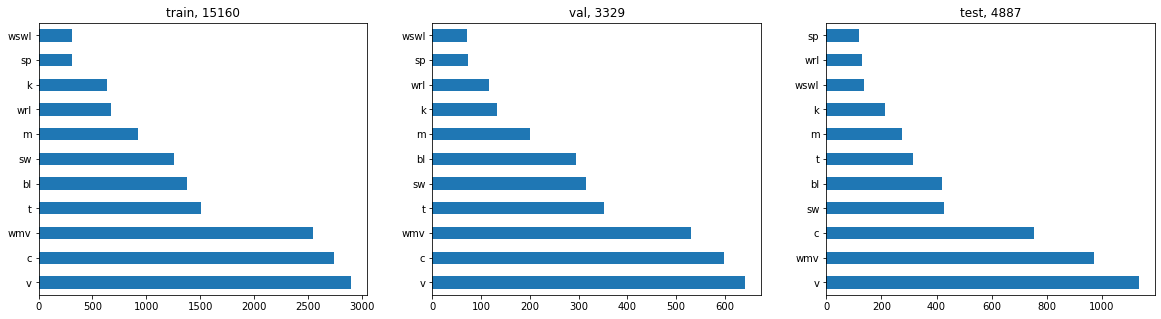

In [5]:
test_plates = train_test_split(df.platename.unique(), random_state=2022, test_size=0.2, shuffle=True)[1].tolist()
testseries = pd.Series(test_plates)
inds = testseries.apply(lambda x: 'wortel' in x)
inds = testseries[inds].sample(11).index.values
wortel_plates = testseries[inds].tolist()
test_plates = testseries[testseries.apply(lambda x: x.split('_')[1] != 'wortel')].tolist() + wortel_plates

df_trainval = df[~df.platename.isin(test_plates)]
df_test = df[df.platename.isin(test_plates)]

topclasses = df['label'].value_counts().head(11).index.tolist()

df = df[df['label'].isin(topclasses)]
df_trainval = df_trainval[df_trainval['label'].isin(topclasses)]
df_test = df_test[df_test['label'].isin(topclasses)]

class_weights = class_weight.compute_class_weight('balanced', 
                                                  classes=np.unique(df['label'].tolist()), 
                                                  y=df['label'].tolist())

class_weights = {np.unique(df['label'])[i]:class_weights[i] for i in range(len(class_weights))}
df['weights'] = df['label'].map(class_weights)

df_train, df_val = train_test_split(df_trainval, test_size=0.18, random_state=42, shuffle=True)


plt.figure(figsize=(20,5))
plt.subplot(1,3,1);df_train.txt_label.value_counts().plot(kind='barh');plt.title(f'train, {df_train.shape[0]}')
plt.subplot(1,3,2);df_val.txt_label.value_counts().plot(kind='barh');plt.title(f'val, {df_val.shape[0]}')
plt.subplot(1,3,3);df_test.txt_label.value_counts().plot(kind='barh');plt.title(f'test, {df_test.shape[0]}');

In [6]:
assert len(set(df_train.filename.tolist()).intersection(df_test.filename.tolist())) == 0
assert len(set(df_train.filename.tolist()).intersection(df_val.filename.tolist())) == 0

In [7]:
df_train.to_parquet(f"{SAVE_DIR}/df_train_{setting}.parquet")
df_val.to_parquet(f"{SAVE_DIR}/df_val_{setting}.parquet")
df_test.to_parquet(f"{SAVE_DIR}/df_test_{setting}.parquet")

In [8]:
df_train.label.value_counts()

8     2899
7     2737
9     2544
3     1502
0     1372
4     1260
6      926
10     669
5      634
2      311
1      306
Name: label, dtype: int64

# Creating Pytorch Datasets and Dataloaders

In [9]:
transforms_list_train = [
#     A.SmallestMaxSize(max_size=150),
#     A.Resize(height=150,width=150,p=1),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225], p=1, always_apply=True),
    A.ShiftScaleRotate(shift_limit=0.01,rotate_limit=45, scale_limit=0, p=.5),
    A.Rotate(limit=90, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    # A.RandomGamma(p=0.5),
     A.RandomBrightnessContrast(p=0.2),
     A.GaussianBlur(blur_limit=(3,3), p=0.1)
]

transforms_list_test = [
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225], 
                p=1, 
                always_apply=True)
]

train_dataset = InsectImgDataset(df=df_train.reset_index(drop=True), transform=A.Compose(transforms_list_train))
valid_dataset = InsectImgDataset(df=df_val.reset_index(drop=True), transform=A.Compose(transforms_list_test))
test_dataset = InsectImgDataset(df=df_test.reset_index(drop=True), transform=A.Compose(transforms_list_test))

batch_size = 32
batch_size_val = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

# plt.imshow(train_dataset[0][0]); plt.title(f"Example train image, class:{train_dataset[0][1]}");

# Defining the model and training parameters

In [10]:
torch.backends.cudnn.benchmark = True

In [11]:
modelname = "vgg16"
model = model_selector(modelname, pretrained=True)

if modelname.startswith("dense"):
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs,len(topclasses))
if modelname.startswith("resn"):
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs,len(topclasses))
if modelname.startswith("efficient"):
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs,len(topclasses))
if modelname.startswith("vgg"):
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, len(topclasses))
    
# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
model = model.to('cuda', dtype=torch.float)

num_epochs = 40

class_sample_count = np.unique(df_train.label, return_counts=True)[1]
weight = 1. / class_sample_count  
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(weight).cuda(), label_smoothing=.1)

Train on gpu: True


In [12]:
optimizer = optim.Adam(model.parameters(), lr=.001)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, cycle_momentum=False, mode="triangular2")

In [13]:
#optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-3, amsgrad=True)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, cycle_momentum=False, mode="triangular2")

# Training

In [ ]:
results = {"loss":[], "val_loss":[], "train_accuracy":[], "valid_accuracy":[]}
best_valacc = 0
# Model training
for epoch in range(num_epochs):
    # Going through the training set
    correct_train = 0
    model.train()
    for x_batch,y_batch,imgname,platename,filename,plate_idx,location,date,year,xtra,width,height in tqdm(train_dataloader, desc='Training..\t'):        
        y_batch = torch.as_tensor(y_batch)
        x_batch,y_batch = x_batch.float().cuda(), y_batch.cuda()
        for param in model.parameters():
            param.grad = None
        pred = model(x_batch)

        y_batch = y_batch.type(torch.LongTensor).cuda()
        correct_train += (pred.argmax(axis=1) == y_batch).float().sum().item()
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
    train_accuracy = correct_train / len(train_dataset) * 100.
    torch.cuda.empty_cache()

    
    # Going through the validation set
    correct_valid = 0
    model.eval()
    with torch.no_grad():
        for x_batch,y_batch,imgname,platename,filename,plate_idx,location,date,year,xtra,width,height in tqdm(valid_dataloader, desc='Validating..\t'):
            y_batch = torch.as_tensor(y_batch)
            x_batch,y_batch = x_batch.float().cuda(), y_batch.cuda()
            pred = model(x_batch)

            y_batch = y_batch.type(torch.LongTensor).cuda()
            correct_valid += (pred.argmax(axis=1) == y_batch).float().sum().item()
            val_loss = criterion(pred, y_batch)
    valid_accuracy = correct_valid / len(valid_dataset) * 100.

    scheduler.step()


    # Printing results
    print(f"Epoch {epoch}: train_acc: {train_accuracy:.1f}% loss: {loss:.7f},  val_loss: {val_loss:.7f} val_acc: {valid_accuracy:.1f}%")
        
    is_best = valid_accuracy > best_valacc
    if is_best:
        print(f"Validation accuracy improved from {best_valacc:.2f} to {valid_accuracy:.2f}. Saving model..")
    best_valacc = max(valid_accuracy, best_valacc)
    save_checkpoint({
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'best_valacc': best_valacc,
        'loss': results['loss'].append(loss.detach().cpu()),
        'val_loss': results['val_loss'].append(val_loss.detach().cpu()),
        'train_accuracy': results['train_accuracy'].append(train_accuracy),
        'valid_accuracy': results['valid_accuracy'].append(valid_accuracy),
        'optimizer' : optimizer.state_dict(),
    }, is_best, f"{modelname}_{setting}")


Validating..	: 100%|██████████████████████████| 105/105 [00:07<00:00, 14.77it/s]


Epoch 0: train_acc: 48.3% loss: 1.5359921,  val_loss: 2.0412858 val_acc: 57.9%
Validation accuracy improved from 0.00 to 57.86. Saving model..


Training..	:  24%|██████▋                     | 113/474 [00:25<01:20,  4.50it/s]